### 7.0 Categorizing Fake News

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('fake_news_data.csv')
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


#### A plot of fake and factual news

##### Let's set our plot options 

In [4]:
plt.rcParams['figure.figsize'] = (12, 8)
default_plot_colour = "#00bfbf"

Text(0.5, 0, 'Classification')

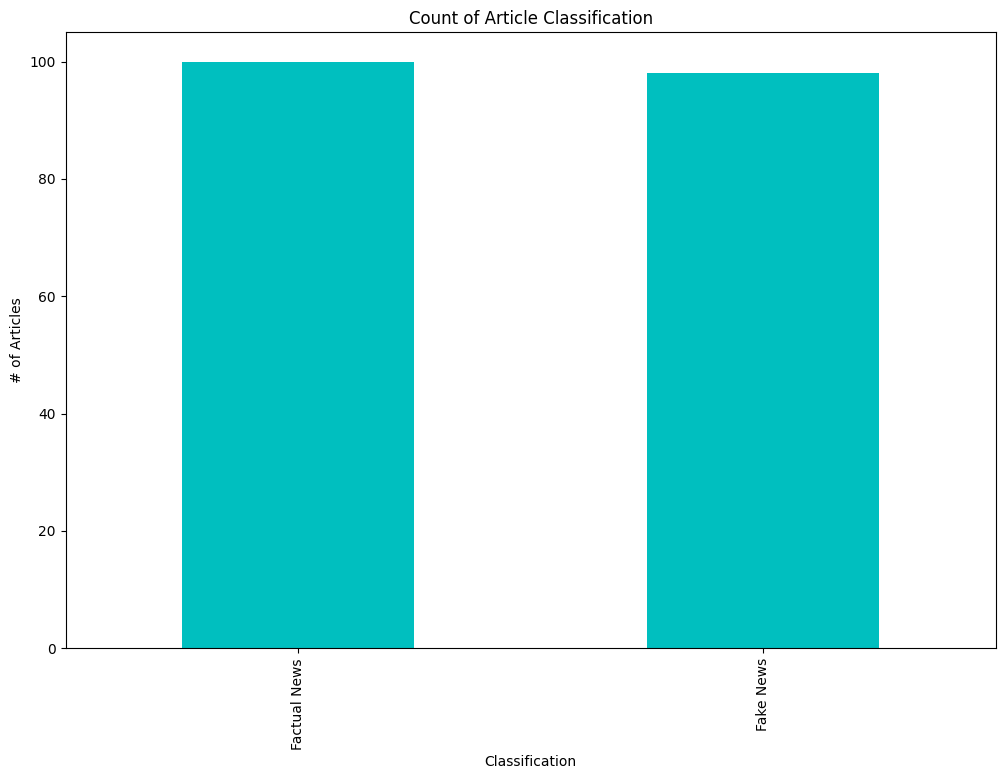

In [5]:
data['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_colour)
plt.title('Count of Article Classification')
plt.ylabel('# of Articles')
plt.xlabel('Classification')

#### Importing packages for data processing and analysis

In [6]:
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

### 7.1 POS Tagging

In [7]:
nlp = spacy.load('en_core_web_sm')

#### Splitting our data into fake and factual news 

In [8]:
fake_news = data[data['fake_or_factual']== 'Fake News']
factual_news = data[data['fake_or_factual']== 'Factual News']

#### Creating spacey documents - use pipe for dataframe

In [9]:
fake_spaceydocs = list(nlp.pipe(fake_news['text']))
fact_spaceydocs = list(nlp.pipe(factual_news['text'])) 

#### Creating function to extract tags for each document in our data

In [10]:
def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

#### Tagging fake dataset 

In [11]:
fake_tagsdf = []
columns = ["token", "ner_tag", "pos_tag"]

for ix, doc in enumerate(fake_spaceydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagsdf.append(tags)
        
fake_tagsdf = pd.concat(fake_tagsdf)   

# tag factual dataset 
fact_tagsdf = []

for ix, doc in enumerate(fact_spaceydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsdf.append(tags)
        
fact_tagsdf = pd.concat(fact_tagsdf)   

In [12]:
fake_tagsdf.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


#### Fake news token frequency count

In [13]:
pos_counts_fake = fake_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fake.head()

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875


#### Factual news token frequency count

In [14]:
pos_counts_fact = fact_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fact.head()

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789


#### Frequencies of pos tags for fake news

In [15]:
pos_counts_fake.groupby(['pos_tag'])['token'].count().sort_values(ascending=False).head()

pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
Name: token, dtype: int64

#### Frequencies of pos tags for factual news

In [16]:
pos_counts_fact.groupby(['pos_tag'])['token'].count().sort_values(ascending=False).head()

pos_tag
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
Name: token, dtype: int64

#### Diferences in nouns (fake news)

In [17]:
pos_counts_fake[pos_counts_fake.pos_tag == "NOUN"][0:10]

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


#### Diferences in nouns (factual news)

In [18]:
pos_counts_fact[pos_counts_fact.pos_tag == "NOUN"][0:10]

,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


### 7.2 Named Entity Recognition- NER

#### Top entities in fake and factual news

In [19]:
# fake news
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ""] \
                    .groupby(['token','ner_tag']).size().reset_index(name='counts') \
                    .sort_values(by='counts', ascending=False)

# factual news
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != ""] \
                    .groupby(['token','ner_tag']).size().reset_index(name='counts') \
                    .sort_values(by='counts', ascending=False)

#### Creating custom palette to ensure plots are consistent

In [20]:
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}

#### Creating an sns plot

[Text(0.5, 1.0, 'Most Common Entities in Fake News')]

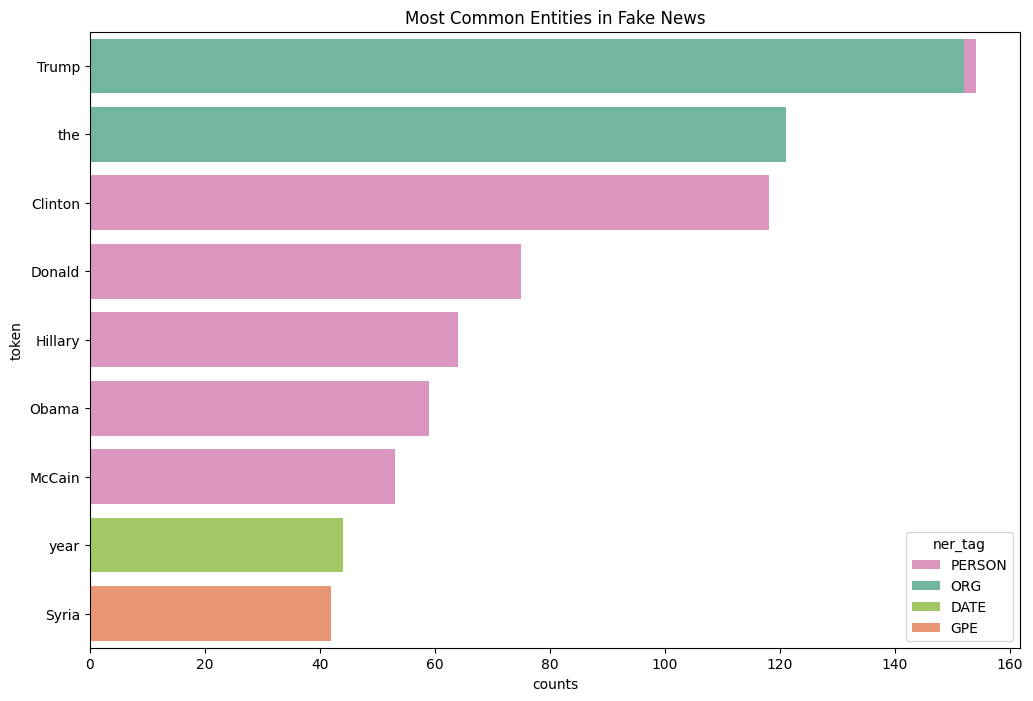

In [21]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fake[0:10],
    orient = 'h',
    dodge=False
) \
.set(title='Most Common Entities in Fake News')

[Text(0.5, 1.0, 'Most Common Entities in Factual News')]

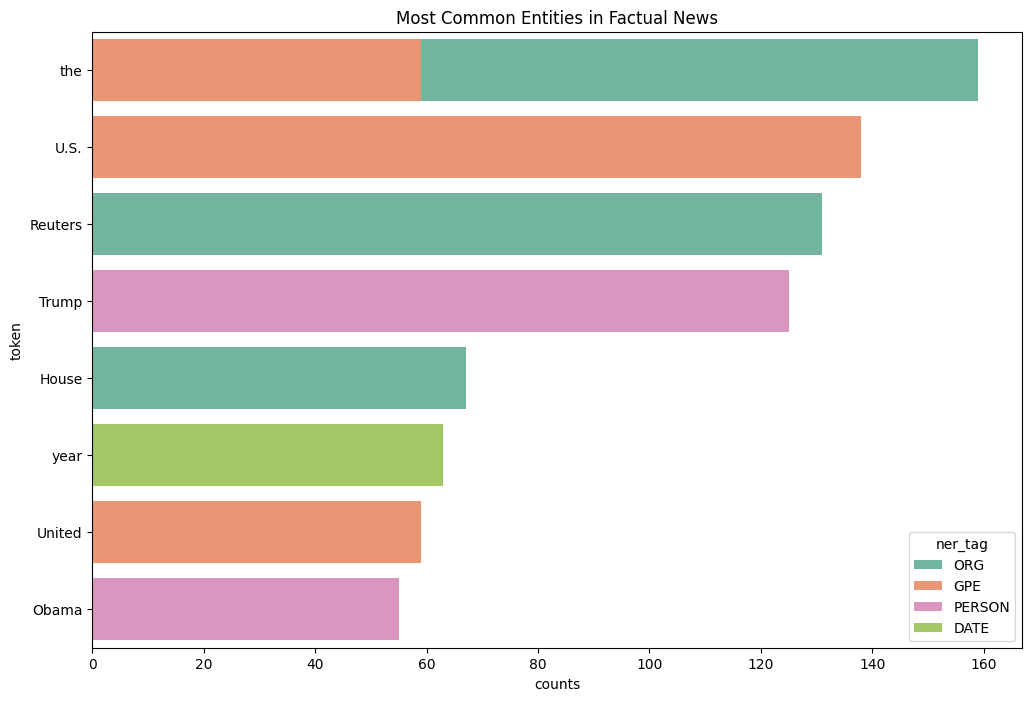

In [22]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fact[0:10],
    orient = 'h',
    dodge=False
) \
.set(title='Most Common Entities in Factual News')

### 7.3 Text Pre-processing

#### Let's use regex to remove the location tag at the beginning of the article- factual news

In [23]:
data['text_clean'] = data.apply(lambda x: re.sub(r"^[^-]*-\s*", "", x['text']), axis=1)

#### Lowercase 

In [24]:
data['text_clean'] = data['text_clean'].str.lower()

#### Removing punctuations

In [25]:
data['text_clean']= data.apply(lambda x: re.sub(r'([^\w\s])', '', x['text_clean']), axis=1)

#### Removing stopwords

In [26]:
en_stopwords = stopwords.words('english')
print(en_stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [27]:
data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))

#### Tokenize

In [28]:
data['text_clean'] = data.apply(lambda x: word_tokenize(x['text_clean']), axis=1)

#### Lemmatize

In [29]:
lemmatizer = WordNetLemmatizer()

data["text_clean"] = data["text_clean"].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [30]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


#### Most common unigrams after data pre-processing

In [31]:
tokens_clean = sum(data['text_clean'], [])
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts()).reset_index()[:10]
print(unigrams)

           index  count
0        (said,)    560
1       (trump,)    520
2           (u,)    255
3       (state,)    250
4   (president,)    226
5       (would,)    210
6         (one,)    141
7        (year,)    128
8  (republican,)    128
9        (also,)    124


#### Extracting the token from the tuple so we can plot it

In [32]:
unigrams['token'] = unigrams['index'].apply(lambda x: x[0]) 

/var/folders/qf/6ns4dg8d0gq5g9dp2kkxry6h0000gn/T/ipykernel_21376/2680314542.py:1: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x = "count",


[Text(0.5, 1.0, 'Most Common Unigrams After Preprocessing')]

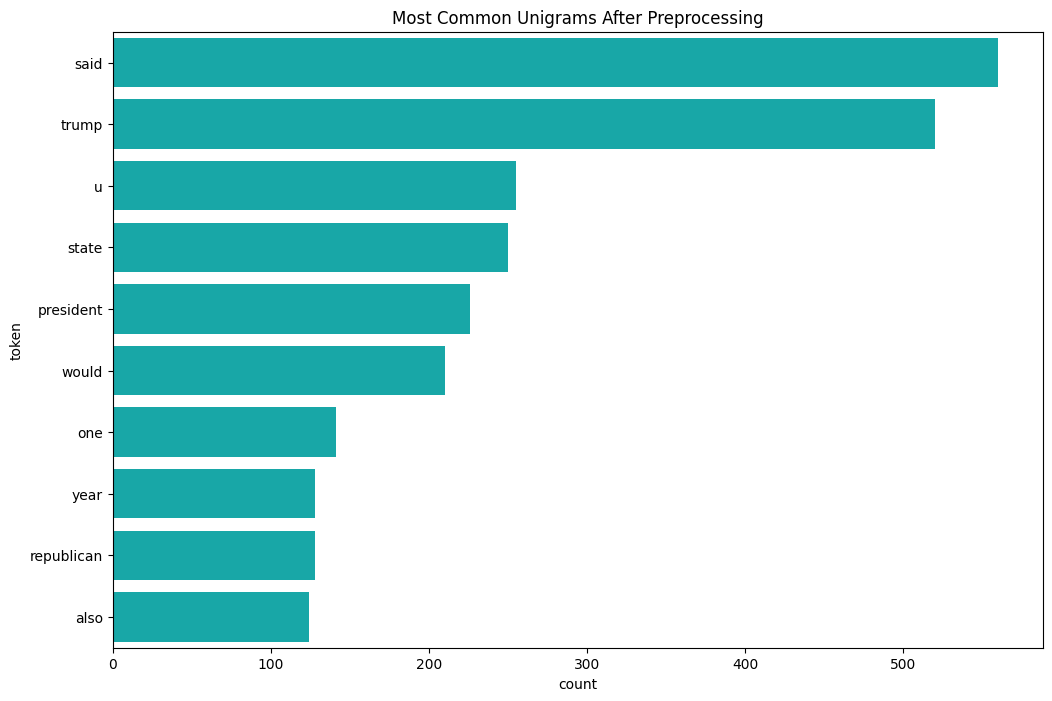

In [33]:
sns.barplot(x = "count", 
            y = "token", 
            data=unigrams,
            orient = 'h',
            palette=[default_plot_colour],
            hue = "token", legend = False)\
.set(title='Most Common Unigrams After Preprocessing')

#### Most common bigrams after pre-processing

In [34]:
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts()).reset_index()[:10]
print(bigrams)

                 index  count
0      (donald, trump)     92
1      (united, state)     80
2       (white, house)     72
3  (president, donald)     42
4   (hillary, clinton)     31
5          (new, york)     31
6         (image, via)     29
7     (supreme, court)     29
8     (official, said)     26
9        (food, stamp)     24


In [35]:
bigrams['token'] = bigrams['index'].apply(lambda x: x[0]) 

/var/folders/qf/6ns4dg8d0gq5g9dp2kkxry6h0000gn/T/ipykernel_21376/96488004.py:1: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x = "count",


[Text(0.5, 1.0, 'Most Common Bigrams After Preprocessing')]

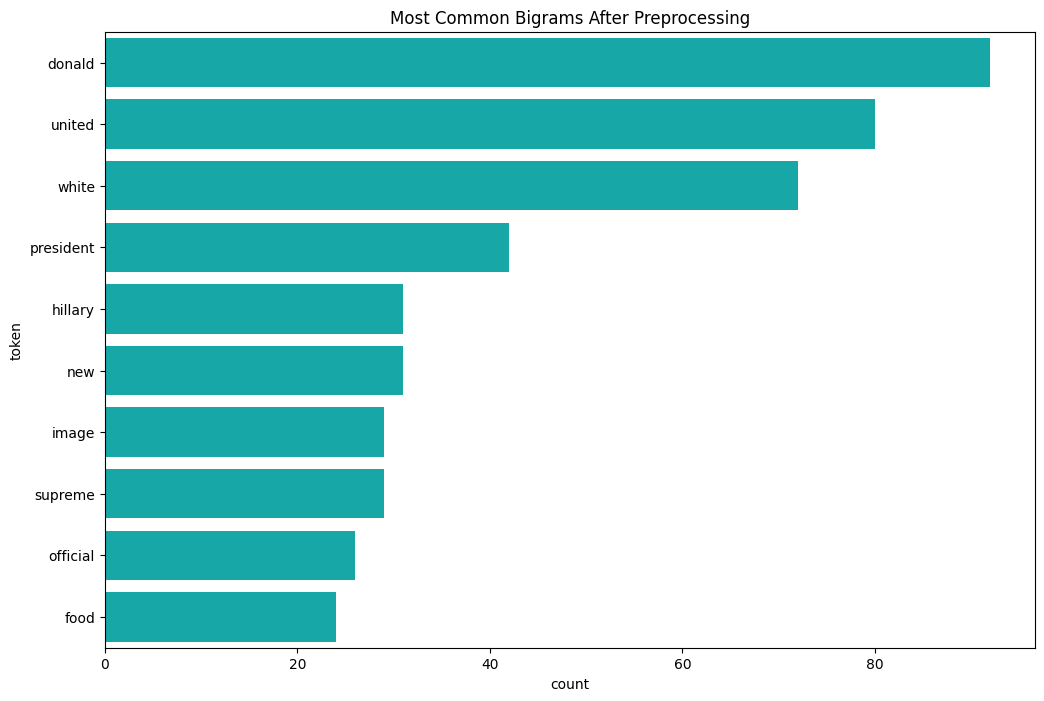

In [36]:
sns.barplot(x = "count", 
            y = "token", 
            data=bigrams,
            orient = 'h',
            palette=[default_plot_colour],
            hue = "token", legend = False)\
.set(title='Most Common Bigrams After Preprocessing')

### 7.4 Sentiment Analysis

#### Vader sentiment analysis 

In [37]:
vader_sentiment = SentimentIntensityAnalyzer()

In [38]:
data['vader_sentiment_score'] = data['text'].apply(lambda review: vader_sentiment.polarity_scores(review)['compound'])

#### Categorizing the sentiment scores

In [39]:
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']

data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels = names)

In [40]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


#### Visualizing the reviews

<Axes: xlabel='vader_sentiment_label'>

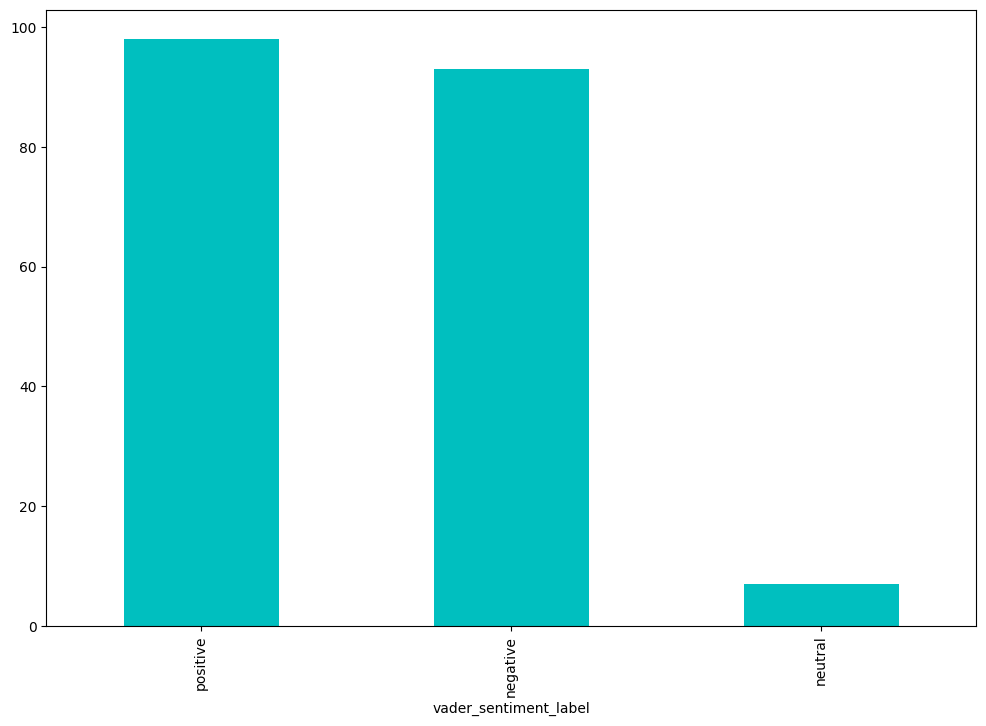

In [41]:
data['vader_sentiment_label'].value_counts().plot.bar(color=default_plot_colour)

/var/folders/qf/6ns4dg8d0gq5g9dp2kkxry6h0000gn/T/ipykernel_21376/3014756626.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment by News Type')]

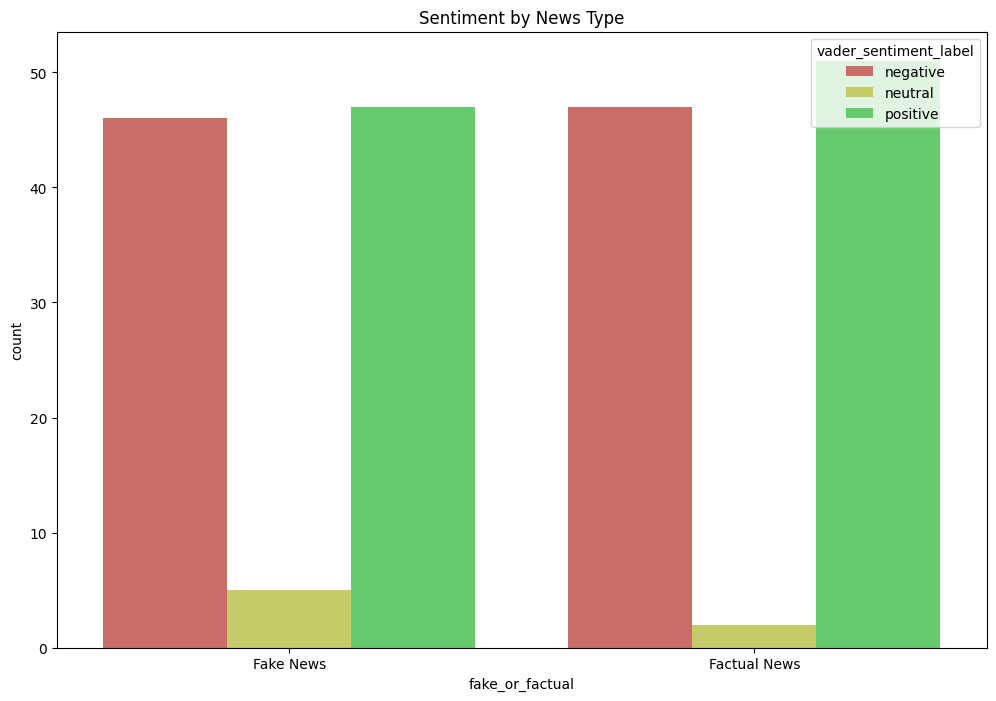

In [42]:
sns.countplot(
    x = 'fake_or_factual',
    hue = 'vader_sentiment_label',
    palette = sns.color_palette("hls"),
    data = data
) \
.set(title='Sentiment by News Type')

### Latent Dirichlet Allocation- LDA

#### Fake news data vectorization

In [43]:
fake_news_text = data[data['fake_or_factual'] == "Fake News"]['text_clean'].reset_index(drop=True)
dictionary_fake = corpora.Dictionary(fake_news_text)
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

#### Generate coherence scores to determine an optimum number of topics

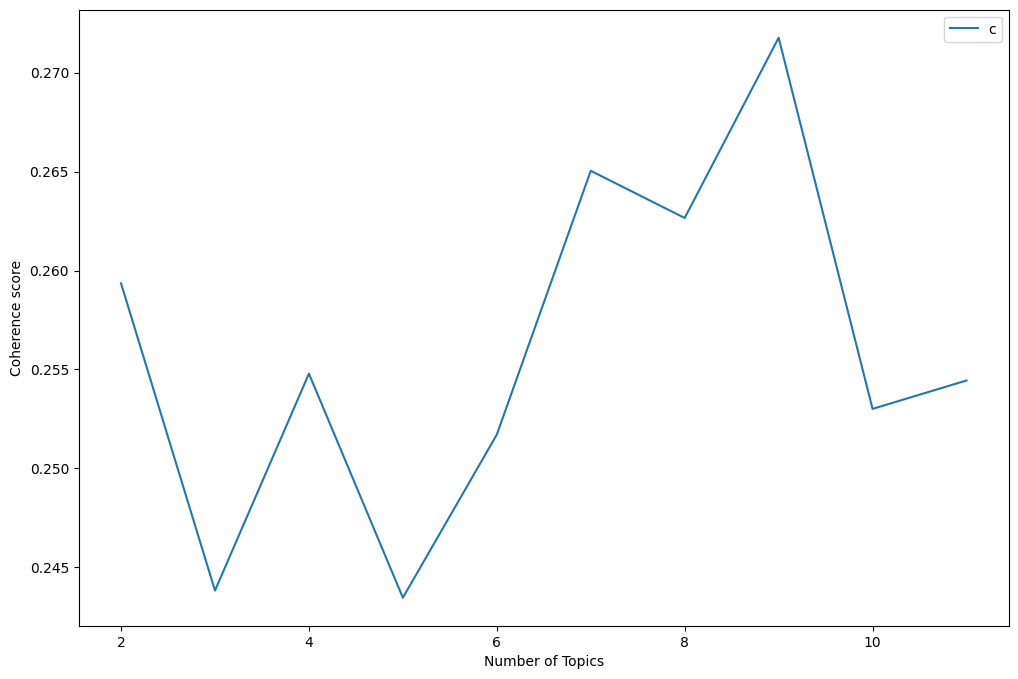

In [44]:
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics=num_topics_i, id2word = dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())
    
plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#### Creating LDA model

In [45]:
num_topics_fake = 8 

lda_model_fake = gensim.models.LdaModel(corpus=doc_term_fake,
                                       id2word=dictionary_fake,
                                       num_topics=num_topics_fake)

lda_model_fake.print_topics(num_topics=num_topics_fake, num_words=10)

[(0,
  '0.009*"trump" + 0.005*"would" + 0.005*"state" + 0.005*"president" + 0.004*"said" + 0.004*"year" + 0.003*"u" + 0.003*"official" + 0.003*"republican" + 0.003*"email"'),
 (1,
  '0.009*"trump" + 0.005*"school" + 0.004*"said" + 0.003*"president" + 0.003*"time" + 0.003*"state" + 0.003*"like" + 0.002*"county" + 0.002*"also" + 0.002*"people"'),
 (2,
  '0.010*"trump" + 0.005*"clinton" + 0.005*"said" + 0.005*"state" + 0.004*"one" + 0.004*"would" + 0.004*"president" + 0.003*"time" + 0.003*"u" + 0.003*"campaign"'),
 (3,
  '0.005*"president" + 0.004*"u" + 0.004*"trump" + 0.003*"one" + 0.003*"clinton" + 0.003*"republican" + 0.003*"year" + 0.003*"said" + 0.003*"state" + 0.003*"woman"'),
 (4,
  '0.019*"trump" + 0.005*"republican" + 0.005*"said" + 0.004*"president" + 0.004*"time" + 0.004*"would" + 0.003*"donald" + 0.003*"state" + 0.003*"one" + 0.003*"image"'),
 (5,
  '0.015*"trump" + 0.006*"clinton" + 0.005*"said" + 0.005*"woman" + 0.004*"state" + 0.004*"time" + 0.004*"would" + 0.003*"go" + 0.0

#### TF-IDF & LSA

In [46]:
def tfidf_corpus(doc_term_matrix):
    # create a corpus using tfidf vectorization
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [47]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    # generate coherence scores to determine an optimum number of topics
    coherence_values = []
    model_list = []
    for num_topics_i in range(min_topics, max_topics+1):
        model = LsiModel(corpus, num_topics=num_topics_i, id2word = dictionary, random_seed=0)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    # plot results
    plt.plot(range(min_topics, max_topics+1), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

#### Creating tfidf representation

In [48]:
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)

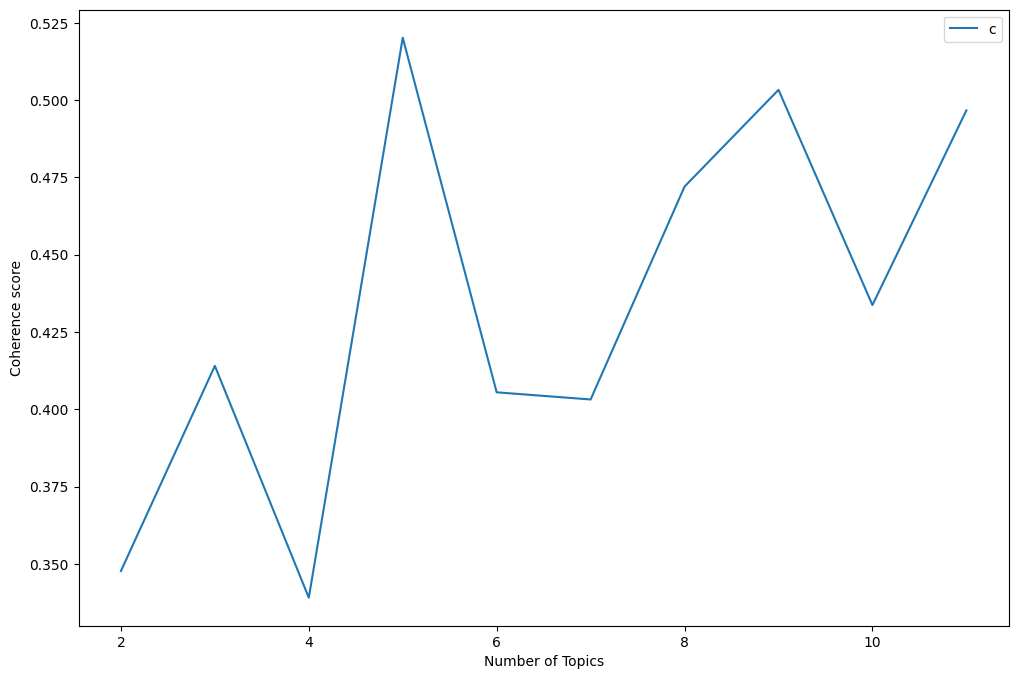

In [49]:
# coherence scores for fake news data
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

#### Model for fake news data

In [50]:
lsa_fake = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=5)
lsa_fake.print_topics()

[(0,
  '-0.218*"trump" + -0.135*"clinton" + -0.094*"woman" + -0.087*"president" + -0.086*"republican" + -0.085*"obama" + -0.084*"party" + -0.083*"school" + -0.081*"said" + -0.079*"time"'),
 (1,
  '-0.299*"boiler" + -0.253*"room" + -0.250*"acr" + -0.186*"jay" + -0.185*"animal" + -0.176*"episode" + -0.147*"analysis" + -0.122*"dyer" + -0.119*"savant" + -0.119*"moralist"'),
 (2,
  '0.219*"school" + -0.195*"clinton" + -0.163*"conference" + 0.151*"county" + 0.137*"student" + -0.120*"press" + -0.116*"trump" + -0.112*"hillary" + 0.101*"love" + -0.095*"email"'),
 (3,
  '-0.375*"flynn" + -0.151*"russian" + -0.111*"email" + -0.109*"30" + -0.101*"department" + -0.100*"information" + -0.100*"nana" + -0.099*"official" + -0.098*"mccain" + 0.096*"trump"'),
 (4,
  '0.235*"trump" + 0.223*"flynn" + 0.166*"conference" + -0.165*"clinton" + -0.153*"dnc" + -0.151*"sander" + -0.127*"email" + 0.111*"press" + -0.109*"rich" + 0.084*"tax"')]

### 7.5 Predicting fake or factual news

#### We now prepare the inputs for our algorithm

In [51]:
X = [','.join(map(str, l)) for l in data['text_clean']]
Y = data['fake_or_factual']

#### Vectorizing our text
We use the BoW approach with the CountVectorizer function- converting text data into BoW

In [52]:
count_vec = CountVectorizer()

In [53]:
count_vec_fit = count_vec.fit_transform(X)

In [54]:
bag_of_words = pd.DataFrame(count_vec_fit.toarray(), columns = count_vec.get_feature_names_out())

#### Splitting our data into training and testing sets

In [55]:
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, Y, test_size=0.3)

#### Logistic Regression Model
We now train our model

In [56]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

#### We now generate prediction to see how the model performs 

In [57]:
y_pred_lr = lr.predict(X_test)

In [58]:
accuracy_score(y_pred_lr, y_test)

0.9

#### Classification report 
We want a more detailed information on the performance

In [59]:
print(classification_report(y_test, y_pred_lr, zero_division = 0))

              precision    recall  f1-score   support

Factual News       1.00      0.84      0.91        37
   Fake News       0.79      1.00      0.88        23

    accuracy                           0.90        60
   macro avg       0.90      0.92      0.90        60
weighted avg       0.92      0.90      0.90        60



#### The Naive-Bayes classifier 

In [60]:
from sklearn.naive_bayes import MultinomialNB

In [61]:
nb = MultinomialNB().fit(X_train, y_train)

In [62]:
y_pred_nb = nb.predict(X_test)

In [63]:
accuracy_score(y_pred_nb, y_test)

0.8833333333333333

In [64]:
print(classification_report(y_test, y_pred_nb, zero_division = 0))

              precision    recall  f1-score   support

Factual News       0.92      0.89      0.90        37
   Fake News       0.83      0.87      0.85        23

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



#### Linear Support Vector Machine

In [65]:
svm = SGDClassifier().fit(X_train, y_train)

In [66]:
y_pred_svm = svm.predict(X_test)

In [67]:
accuracy_score(y_pred_svm, y_test)

0.8833333333333333

In [68]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.94      0.86      0.90        37
   Fake News       0.81      0.91      0.86        23

    accuracy                           0.88        60
   macro avg       0.87      0.89      0.88        60
weighted avg       0.89      0.88      0.88        60

